In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, glob, inspect, sys
from sksurv.ensemble import RandomSurvivalForest
from sksurv.datasets import load_gbsg2
from sksurv.metrics import concordance_index_ipcw
import sksurv
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 
import epri_mc_lib_3 as mc
from importlib import reload
reload(mc)


/home/nick/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/nick/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.


<module 'epri_mc_lib_3' from '/home/nick/Bureau/Programming/S2DS/Oct20_EPRI/Task3/NB/epri_mc_lib_3.py'>

Do random survival forest analysis on the simulated data

In [2]:
data = pd.read_csv(os.path.join(os.path.dirname(os.getcwd()), '../Data/Merged_data/CopulaGAN_simulated_data_survival_2.csv'),
                  index_col=0)
data.reset_index(inplace=True)
#data = data.drop(columns=['NDE_cycle'])

## Format data

In [3]:
data_x = data.iloc[:, 2:]
data_y = data.iloc[:, 0:2]
data_y

,Observed,F_Time
0,True,3.650498e+05
1,True,1.146995e+06
2,True,6.493515e+05
3,True,9.246254e+05
4,True,5.521059e+05
...,...,...
995,True,4.542517e+05
996,True,2.449483e+05
997,False,1.953314e+06
998,False,5.054954e+05


In [4]:

X_train, X_test, y_train, y_test = train_test_split(
    data_x, data_y, test_size=0.25)

In [5]:
y_train_num = y_train.to_records(index=False)
y_test_num = y_test.to_records(index=False)


## Random survival forest

In [6]:
rsf = RandomSurvivalForest(n_estimators=5000,
                           max_features="auto",
                          oob_score=True
                          )
rsf.fit(X_train, y_train_num)


RandomSurvivalForest(bootstrap=True, max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None, min_samples_leaf=3,
                     min_samples_split=6, min_weight_fraction_leaf=0.0,
                     n_estimators=5000, n_jobs=None, oob_score=True,
                     random_state=None, verbose=0, warm_start=False)

## Out of bag score (Concordance index)

The out of bag score for random survival forests is the concordance index that is a measure of whether samples are properly ordered relative to one another. 0.5 indicates random ordering and 1 indicates perfect ordering. 

In [7]:
rsf.oob_score_

0.9172827500556525

## Making predictions

THe predictions are a risk score, the expected number of deathes for a terminal node. This doesn't seem to be super useful. The rsf.score gives the concordance index for the test data.

In [8]:
y_pred = pd.Series(rsf.predict(X_test))


0      286.602567
1       25.080773
2      153.307867
3        8.965990
4      412.326563
          ...    
245      2.127457
246      1.055790
247     55.774123
248    284.807137
249    148.637057
Length: 250, dtype: float64

More conservative version of the CI to handle high levels of censored data.

In [9]:
concordance_index_ipcw(y_train_num, y_test_num, y_pred)

(0.8446605684440855, 17224, 1607, 0, 0)

CI score for test data.

In [10]:
rsf.score(X_test,y_test_num)

0.9146619935213213

Predict survival functions.

In [11]:
surv = rsf.predict_survival_function(X_test, return_array=False)

Calculate the median survival so that we can predict a specific number.

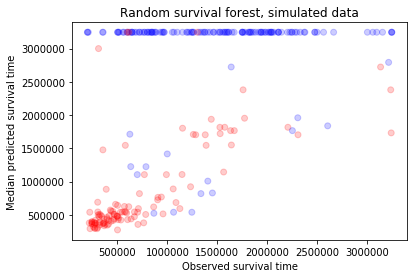

In [12]:
median_survival_list = mc.calc_median_survival(surv)
colordict = {False:'blue', True:'red'}
plt.scatter(x=y_test.F_Time,y=median_survival_list,c=[colordict[c] for c in y_test.Observed],alpha=0.2)
plt.ylabel("Median predicted survival time")
plt.xlabel("Observed survival time")
plt.title("Random survival forest, simulated data")
plt.show()

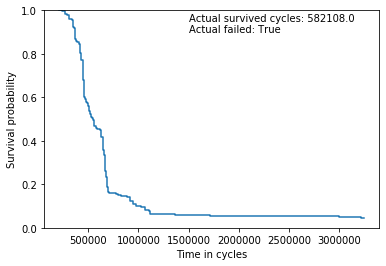

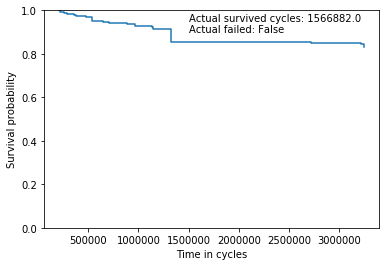

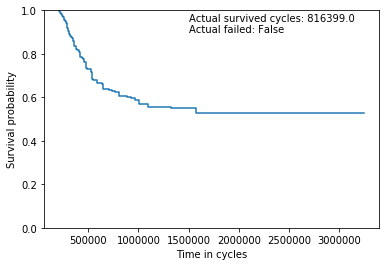

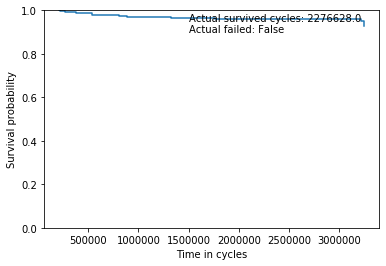

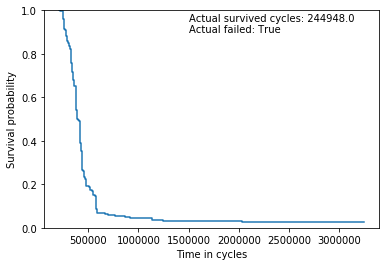

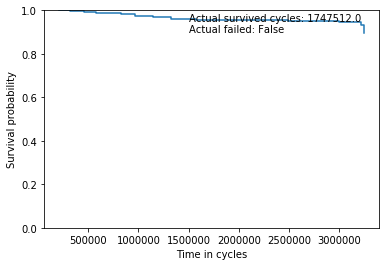

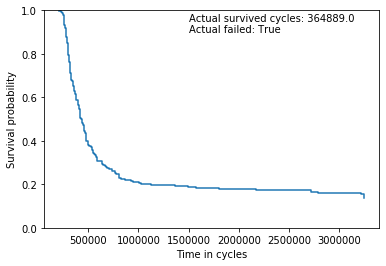

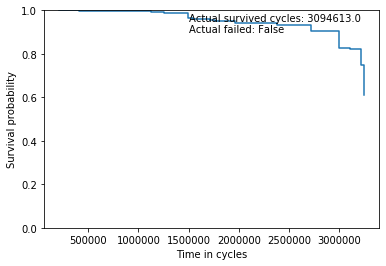

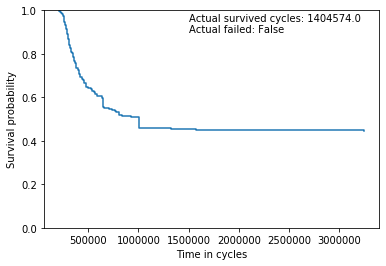

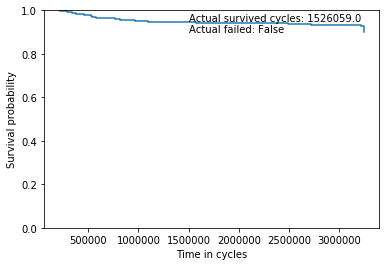

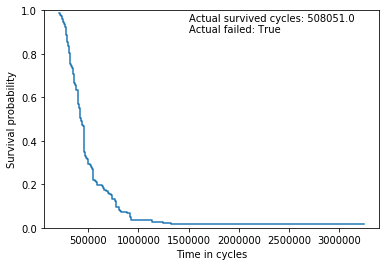

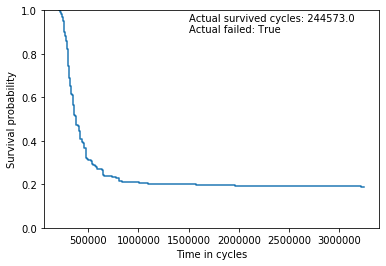

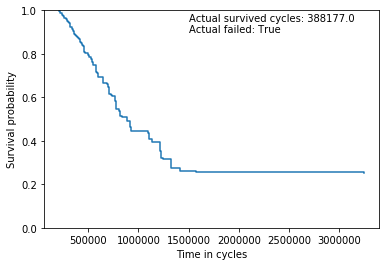

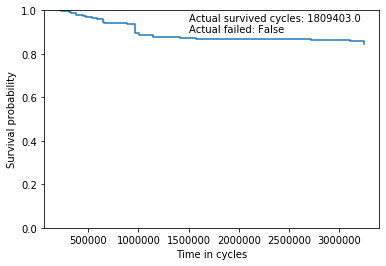

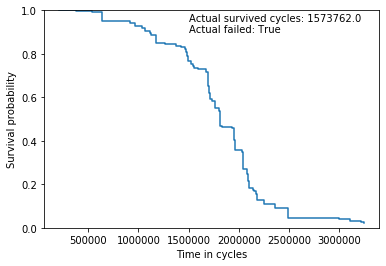

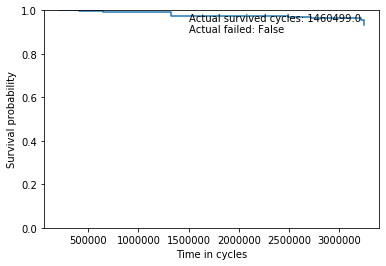

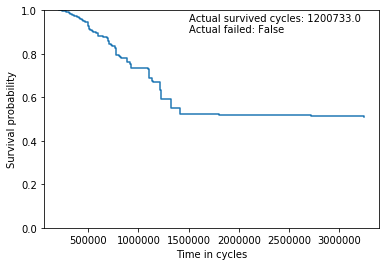

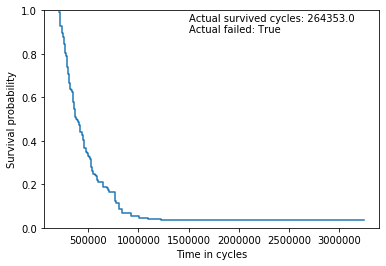

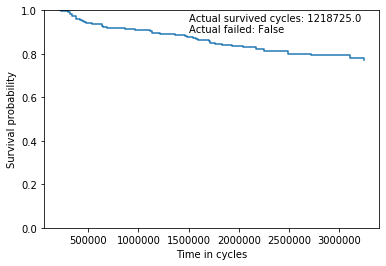

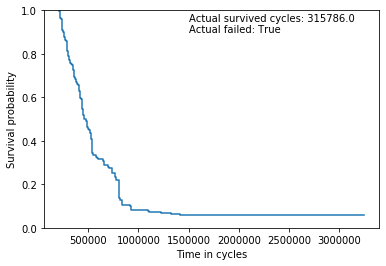

In [13]:
surv = rsf.predict_survival_function(X_test, return_array=False)

i=0
while i < 20: #X_test.shape[0]:
    fn = surv[i]
    plt.step(fn.x, fn(fn.x), where="post")
    plt.ylabel("Survival probability")
    plt.xlabel("Time in cycles")
    plt.ylim(0,1)
    plt.text(1500000, 0.95, 'Actual survived cycles: '+str(np.round(y_test.iloc[i,1],0)))
    plt.text(1500000, 0.90, 'Actual failed: '+str(y_test.iloc[i,0]))
    plt.show()
    i+=1

## Test on the real data

Calculate the concordance index. Get the CI score for the data.

In [14]:
data_real = pd.read_csv(os.path.join(os.path.dirname(os.getcwd()), '../Data/Merged_data/Survival_df.csv'),
                  index_col=0)
#data_real.drop(columns=['NLE_ratio_119_17'],inplace=True)
#data_real = data_real.drop(columns=['NDE_cycle'])

real_x = data_real.iloc[:, 2:]
real_y = data_real.iloc[:, 0:2]
real_y_num = real_y.to_records(index=False)

print(rsf.score(real_x,real_y_num))

surv = rsf.predict_survival_function(real_x, return_array=False)
y_pred_real = pd.Series(rsf.predict(real_x))


0.8958333333333334


Conservative ipcw version of the CI score.

In [15]:
concordance_index_ipcw(y_train_num, real_y_num, y_pred_real)

(0.7737203643398037, 129, 15, 0, 0)

Convert survival function to median expected survival time.

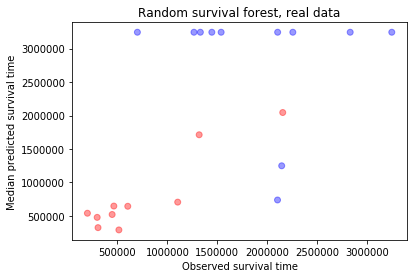

In [16]:

median_survival_list = mc.calc_median_survival(surv)
colordict = {False:'blue', True:'red'}
plt.scatter(x=real_y.F_Time,y=median_survival_list,c=[colordict[c] for c in real_y.Observed],alpha=0.4)
plt.ylabel("Median predicted survival time")
plt.xlabel("Observed survival time")
plt.title("Random survival forest, real data")
plt.show()


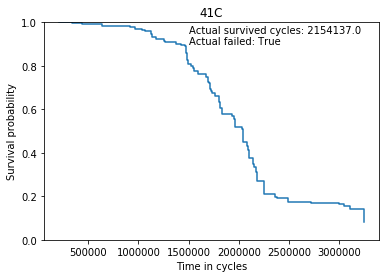

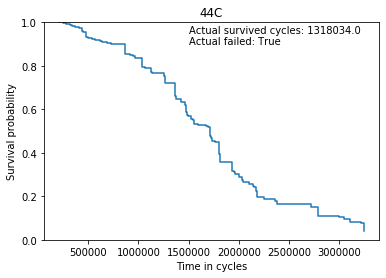

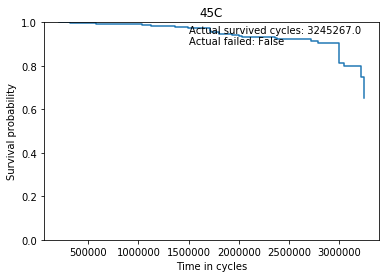

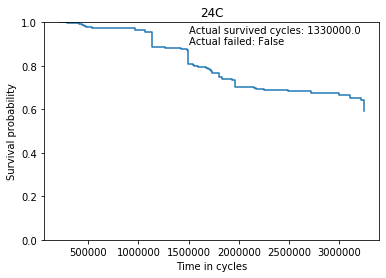

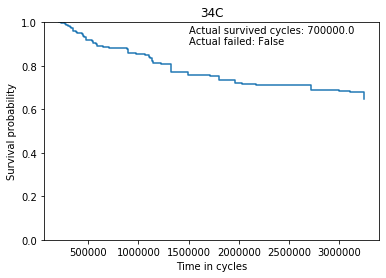

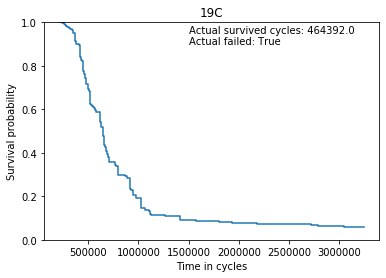

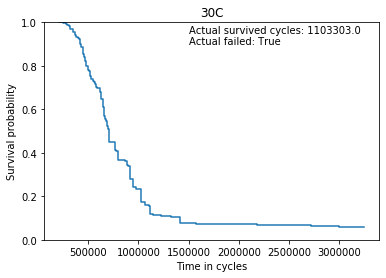

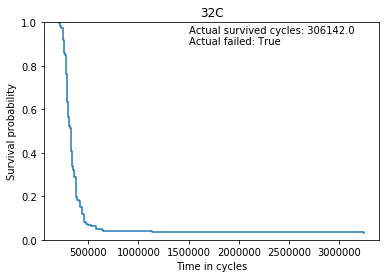

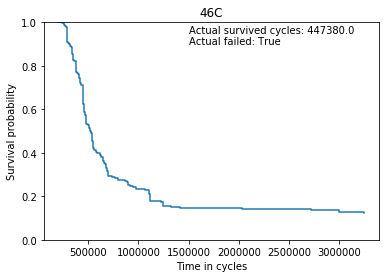

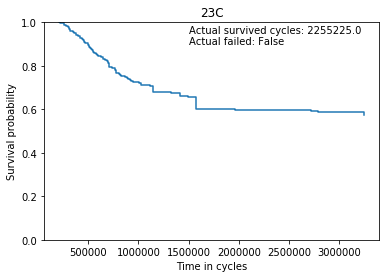

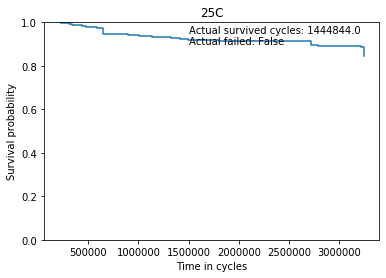

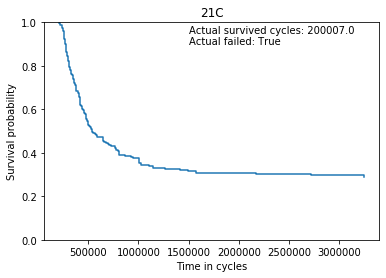

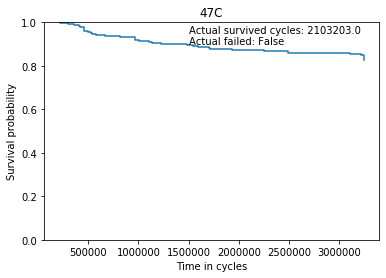

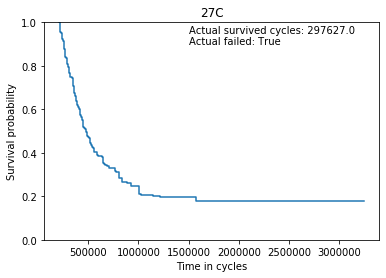

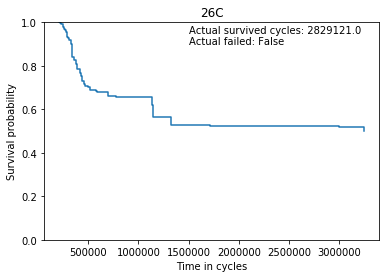

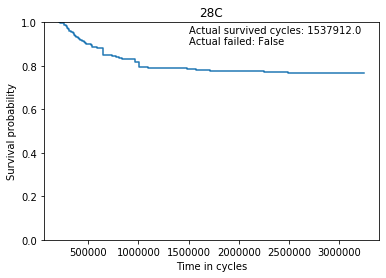

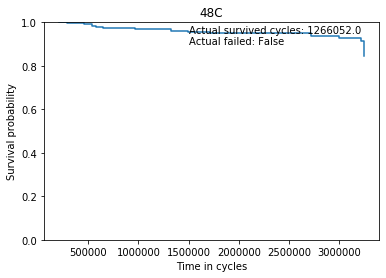

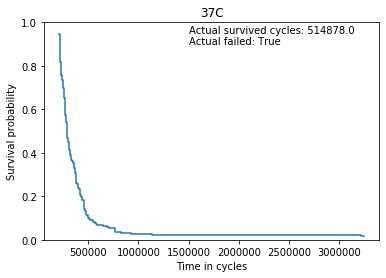

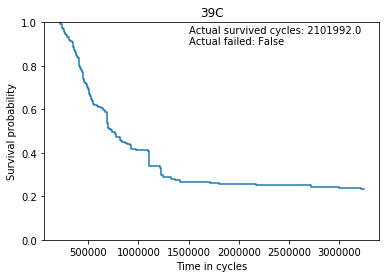

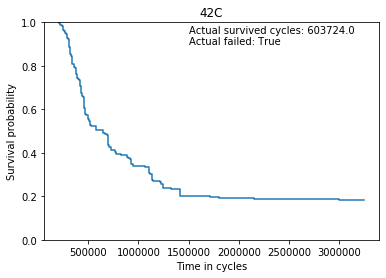

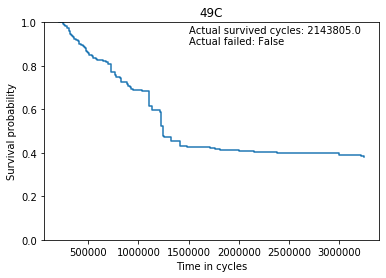

In [17]:

i=0

while i < real_x.shape[0]:
    print()
    fn = surv[i]
    plt.step(fn.x, fn(fn.x), where="post")
    plt.ylabel("Survival probability")
    plt.xlabel("Time in cycles")
    plt.ylim(0,1)
    plt.text(1500000, 0.95, 'Actual survived cycles: '+str(real_y.iloc[i,1]))
    plt.text(1500000, 0.90, 'Actual failed: '+str(real_y.iloc[i,0]))
    plt.title(real_x.index[i])
    plt.show()
    i+=1


## Feature importance by permutation

This estimates the importance of each feature by permutating it and looking at the effect on the model. This is not good when the features are correlated as they are in this case. We test on a subset of the features.

In [18]:
data_x = data.iloc[:, 2:]
data_y = data.iloc[:, 0:2]
df_features = data_x[mc.feature_selection]

X_train, X_test, y_train, y_test = train_test_split(
    df_features, data_y, test_size=0.25)
y_train_num = y_train.to_records(index=False)
y_test_num = y_test.to_records(index=False)


In [19]:

rsf = RandomSurvivalForest(n_estimators=1000,
                           max_features="auto",
                          oob_score=True
                          )
rsf.fit(X_train, y_train_num)
rsf.oob_score_

0.888727216576889

In [20]:
y_pred = pd.Series(rsf.predict(X_test))
rsf.score(X_test,y_test_num)

0.8982014571763387

In [21]:
perm = PermutationImportance(rsf, n_iter=15)
perm.fit(X_test, y_test_num)

PermutationImportance(cv='prefit',
                      estimator=RandomSurvivalForest(bootstrap=True,
                                                     max_depth=None,
                                                     max_features='auto',
                                                     max_leaf_nodes=None,
                                                     max_samples=None,
                                                     min_samples_leaf=3,
                                                     min_samples_split=6,
                                                     min_weight_fraction_leaf=0.0,
                                                     n_estimators=1000,
                                                     n_jobs=None,
                                                     oob_score=True,
                                                     random_state=None,
                                                     verbose=0,
                                   

In [22]:
feature_names = X_test.columns.tolist()
eli5.show_weights(perm, feature_names=feature_names)

Weight,Feature
0.2565 ± 0.0774,NDE_cycle
0.0479 ± 0.0139,NLE_ratio_85_17
0.0272 ± 0.0148,NLO_avg
0.0124 ± 0.0058,pos_ratio
0.0118 ± 0.0071,amp_ratio


Calculate the concordance index and important features with a subset of features that without number of cycles.

In [23]:
data_x = data.iloc[:, 2:]
data_y = data.iloc[:, 0:2]
df_features = data_x[mc.feature_selection2]

X_train, X_test, y_train, y_test = train_test_split(
    df_features, data_y, test_size=0.25)
y_train_num = y_train.to_records(index=False)
y_test_num = y_test.to_records(index=False)


In [24]:

rsf = RandomSurvivalForest(n_estimators=1000,
                           max_features="auto",
                          oob_score=True
                          )
rsf.fit(X_train, y_train_num)
rsf.oob_score_

0.8650452917018612

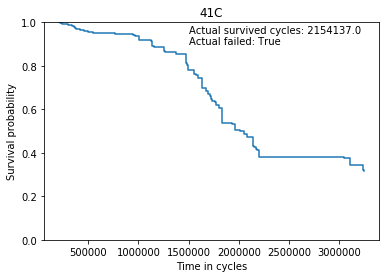

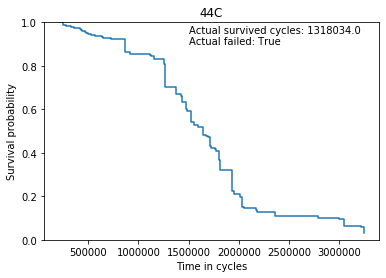

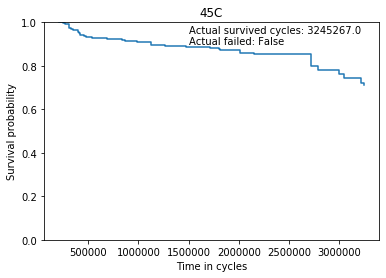

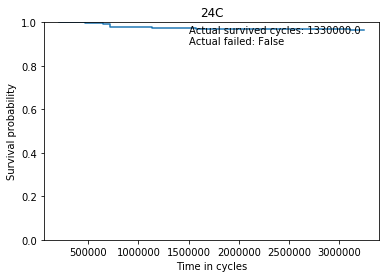

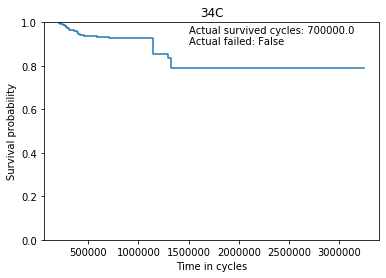

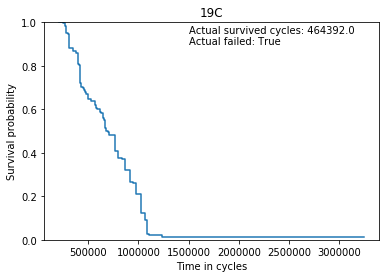

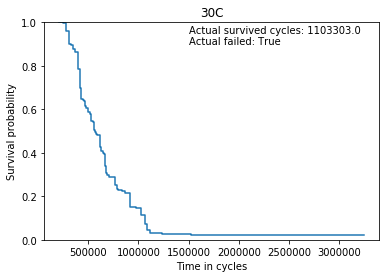

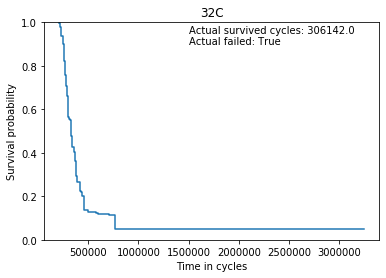

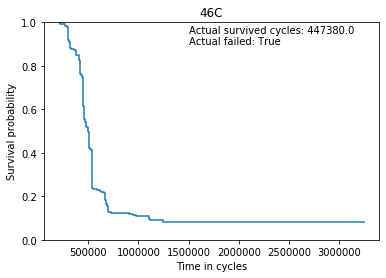

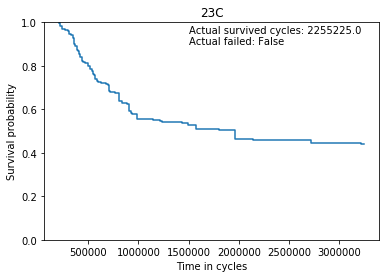

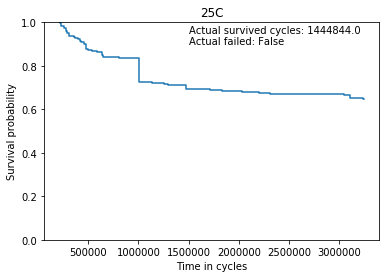

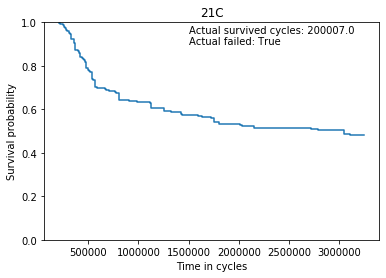

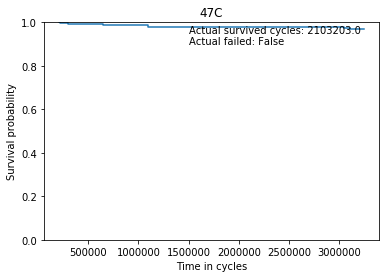

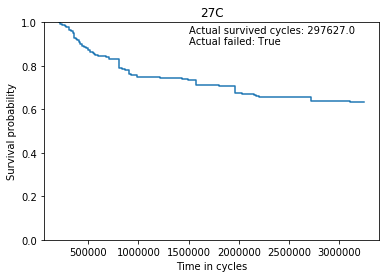

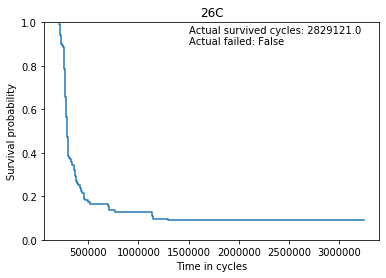

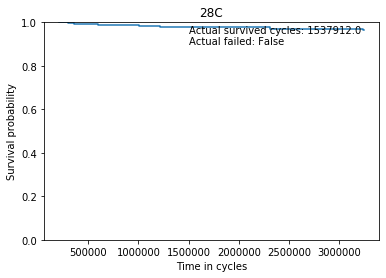

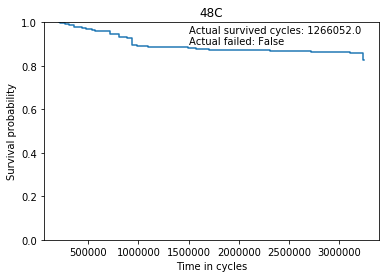

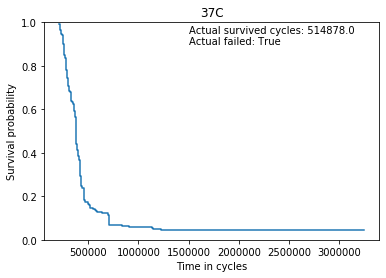

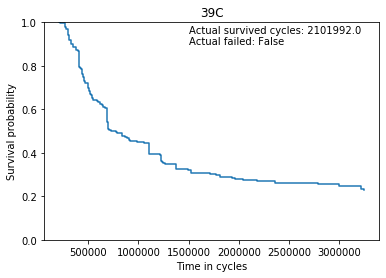

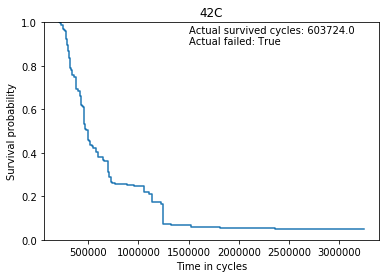

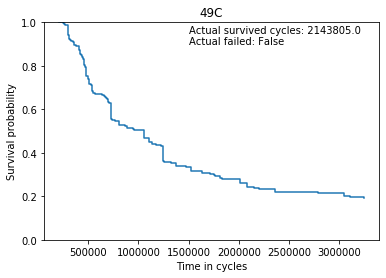

In [25]:
surv = rsf.predict_survival_function(real_x[mc.feature_selection2], return_array=False)

i=0

while i < real_x.shape[0]:
    print()
    fn = surv[i]
    plt.step(fn.x, fn(fn.x), where="post")
    plt.ylabel("Survival probability")
    plt.xlabel("Time in cycles")
    plt.ylim(0,1)
    plt.text(1500000, 0.95, 'Actual survived cycles: '+str(real_y.iloc[i,1]))
    plt.text(1500000, 0.90, 'Actual failed: '+str(real_y.iloc[i,0]))
    plt.title(real_x.index[i])
    plt.show()
    i+=1


In [26]:
y_pred = pd.Series(rsf.predict(X_test))
rsf.score(X_test,y_test_num)

0.8672279792746114

In [27]:
perm = PermutationImportance(rsf, n_iter=15)
perm.fit(X_test, y_test_num)

PermutationImportance(cv='prefit',
                      estimator=RandomSurvivalForest(bootstrap=True,
                                                     max_depth=None,
                                                     max_features='auto',
                                                     max_leaf_nodes=None,
                                                     max_samples=None,
                                                     min_samples_leaf=3,
                                                     min_samples_split=6,
                                                     min_weight_fraction_leaf=0.0,
                                                     n_estimators=1000,
                                                     n_jobs=None,
                                                     oob_score=True,
                                                     random_state=None,
                                                     verbose=0,
                                   

In [28]:
feature_names = X_test.columns.tolist()
eli5.show_weights(perm, feature_names=feature_names)

Weight,Feature
0.2184 ± 0.0442,NLE_ratio_85_17
0.1331 ± 0.0255,Avg_RP
0.0167 ± 0.0098,pos_ratio
0.0155 ± 0.0176,NLO_avg
0.0154 ± 0.0110,amp_ratio


Calculate concordance and feature importance with only NLO for comparison.

In [29]:
data_x = data.iloc[:, 2:]
data_y = data.iloc[:, 0:2]
df_features = pd.DataFrame(data_x['NLO_avg'])

X_train, X_test, y_train, y_test = train_test_split(
    df_features, data_y, test_size=0.25)
y_train_num = y_train.to_records(index=False)
y_test_num = y_test.to_records(index=False)

rsf = RandomSurvivalForest(n_estimators=1000,
                           max_features="auto",
                          oob_score=True
                          )
rsf.fit(X_train, y_train_num)
print(rsf.oob_score_)

y_pred = pd.Series(rsf.predict(X_test))
print(rsf.score(X_test,y_test_num))

perm = PermutationImportance(rsf, n_iter=15)
perm.fit(X_test, y_test_num)

feature_names = X_test.columns.tolist()
eli5.show_weights(perm, feature_names=feature_names)

0.5798730380828406
0.6682457732894588


Weight,Feature
0.1685 ± 0.0498,NLO_avg
